In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib


from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.7896346444957159,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -5,
 'psh_log_f_max': -3.5,
 'N_psh': 500,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy'}

In [4]:
# p = update_params(param_file, p, 'exposure', 5 * 14000 / (4 * np.pi))

In [5]:
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)
fluxes = fluxes[:-55]
np.log10(fluxes[-1])

-2.8706827309236953

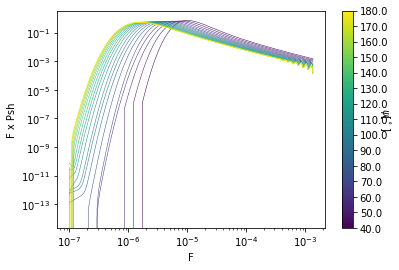

In [6]:
numnum = 20
psis = np.linspace(40, 180, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = fluxes
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
#     print(np.trapz(fxs * pshfunc2d(psi, fxs).flatten(), fxs))
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs);

In [7]:
pshfunc2d(psis, fluxes).shape, psis.shape, fluxes.shape

((195, 20), (20,), (195,))

In [8]:
for psi in psis:
    minn = pshfunc2d(psi, fluxes).argmin()
    print(psi, pshfunc2d(psi, fluxes)[minn])

40.0 [0.]
47.368421052631575 [0.]
54.73684210526316 [0.]
62.10526315789474 [-2.40612127e-07]
69.47368421052632 [-1.08275457e-06]
76.84210526315789 [-1.35459412e-06]
84.21052631578948 [1.24189836e-06]
91.57894736842105 [6.06540398e-06]
98.94736842105263 [1.03529737e-05]
106.3157894736842 [4.82912706e-06]
113.68421052631578 [6.59501744e-05]
121.05263157894737 [0.00024274]
128.42105263157896 [0.00040166]
135.78947368421052 [-0.0001204]
143.1578947368421 [-0.00176458]
150.5263157894737 [-0.00507399]
157.89473684210526 [-0.00980803]
165.26315789473682 [-0.01309698]
172.6315789473684 [-0.01504543]
180.0 [-0.01562145]


In [9]:
counts = np.arange(0, 20)
exposure = p['exposure']
psi = 40

In [10]:
from scipy.stats import poisson
print(poisson.pmf(counts[:, np.newaxis], exposure * fluxes).shape, pshfunc2d(40, fluxes).flatten().shape)

pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
# func = pshfunc2d(40, fluxes).flatten() * poisson.pmf(2, exposure * fluxes)
pcvals

(20, 195) (195,)


array([9.02644331e-01, 8.27460081e-02, 9.13474659e-03, 2.32940445e-03,
       1.03267905e-03, 5.70031985e-04, 3.42719291e-04, 2.11070443e-04,
       1.28669549e-04, 7.60890818e-05, 4.31420999e-05, 2.33048671e-05,
       1.19569097e-05, 5.82040813e-06, 2.68852205e-06, 1.17943814e-06,
       4.92030193e-07, 1.95484107e-07, 7.40841370e-08, 2.68247153e-08])

In [11]:
print(exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))
pp = poisson.pmf(counts, exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))

0.12120813252273883


Text(0, 0.5, 'P(C) for 40 deg, n=0')

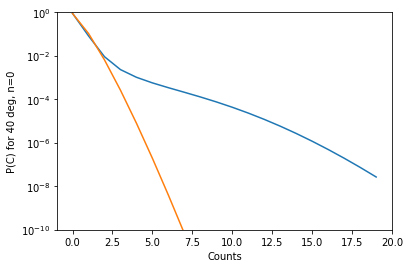

In [12]:
plt.plot(counts, pcvals)
plt.plot(counts, pp)
ax = plt.gca()

ax.set_yscale('log')
ax.set_ylim(top=1, bottom=1e-10)
ax.set_xlim(right=20)
ax.set_xlabel('Counts')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [13]:
import healpy

In [14]:
nside = p['nside']
npix = healpy.nside2npix(nside)
pixel_counts = np.ones(npix) * healpy.pixelfunc.UNSEEN
print(npix)

196608


In [15]:
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
ang_dists, lon, lat

(array([89.74156502, 90.25843498, 90.25843498, ..., 90.25843498,
        90.25843498, 89.74156502]),
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]))

In [16]:
lon, lat, max(ang_dists), min(ang_dists)

(array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]),
 179.70158313251247,
 0.2984168674875423)

In [17]:
print(healpy.nside2pixarea(128, degrees=True))

0.2098234113027917


In [18]:
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([np.trapz(pshfunc2d(abs(psi), fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

In [19]:
good_indices = (abs(lat) >= 40)

In [20]:
# subsample = ang_dists[good_indices]
# print(len(subsample))
# sub_counts = np.zeros(len(subsample))
# for i, psi in enumerate(subsample):
#     if i % 10000 == 0:
#         print(i, '/', len(subsample))
# #     print(psi)
#     pcvals = pc_of_psi(abs(psi))
#     sub_counts[i] = np.random.choice(np.arange(len(pcvals)), size=1, p=pcvals/np.sum(pcvals))
    
# pixel_counts[good_indices] = sub_counts
# pixel_counts_pc = pixel_counts[:]

In [21]:
np.sum(pixel_counts > 0)

0

In [22]:
# nreduce = 64
# healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
# print(healpy.nside2pixarea(nreduce, degrees=True))
# np.mean(pixel_counts_pc[good_indices]), np.sum(pixel_counts_pc[good_indices])

In [23]:
# lsub = len(subsample)
# pixel_counts_poisson = np.ones(npix) * healpy.pixelfunc.UNSEEN
# sub_counts = np.zeros(lsub)
# for i, psi in enumerate(subsample):
#     if i % 100000 == 0:
#         print(i, '/', lsub)
# #     print(psi)
#     sub_counts[i] = stats.poisson.rvs(exposure*np.trapz(fluxes * pshfunc2d(psi, fluxes).flatten(), fluxes))
#     if sub_counts[i] > 5: 
#         print(sub_counts[i])
    
# pixel_counts_poisson[good_indices] = sub_counts


In [24]:
# healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_poisson), nreduce, pess=True, power=-2), cmap=cm.jet, title="Poisson", max=14)
# np.mean(pixel_counts_poisson[good_indices]), np.sum(pixel_counts_poisson[good_indices])

In [25]:
importlib.reload(pd)
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

# restrict to valid range of flux calculation
valid_lim = -55
fluxes = fluxes[:valid_lim]
psh2d = psh2d[:valid_lim]

p['exposure'] = exposure * 5
# generate data with different fwimp
# p['fwimp'] *= 5
f = p['fwimp']*50
# fluxes *= f
# psh2d /= f

# get psh data as function of psi and flux
counts = np.arange(0, 500)
psh2d[psh2d < 0] = 0
pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)

# make the simulated skymap
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([integrate.simps(1/f * pshfunc2d(abs(psi), fluxes).flatten() * stats.poisson.pmf(counts[:, np.newaxis], p['exposure'] * f * fluxes), f * fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

# add backgrounds
background = True

# subcounts, ang_dists, _ = pd.generate_skymap_sample_pc_2(p, pshfunc2d, fluxes, return_subcounts=True, save_output=True, with_bg=background)
subcounts, ang_dists, _ = pd.generate_skymap_sample_pc(p, pc_of_psi, return_subcounts=True, save_output=True, with_bg=background)
print(subcounts)

# get psh for the angles we are considering 
psh = pshfunc2d(np.abs(ang_dists), fluxes)
psh /= integrate.simps(psh, fluxes, axis=0)
print(ang_dists.shape, psh.shape, fluxes.shape)

saved in ./output/n0_skymap_84046.npy
[49. 61. 59. ... 55. 55. 81.]
(70144,) (195, 70144) (195,)


In [26]:
# pc_psi

In [27]:
importlib.reload(pd)
import time
start_time = time.time()
num_search = 100
fwimp_search = (np.log10(f)-2, np.log10(f)+2, num_search)

# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg
# bg_count = np.array([0])

# use different subcoutns?
# subcounts = np.load('./output/n0_skymap_23454.npy')[good_indices]

counts = np.arange(0, max(subcounts)+1)

# chop up psh to get avoid mem error
# fluxes = fluxes[::3]
# psh = psh[::3]

S, fwimps = pd.likelihood(p, psh, subcounts.astype(np.int16), fluxes, counts, fwimp_limits=fwimp_search, bg_count=bg_count, verbose=True)

print('time per eval', (time.time() - start_time)/num_search)

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
time per eval 1.2957142806053161


1.7896346444957159 fwimp: 77.82664735501899 	 S: 602605.5128864672


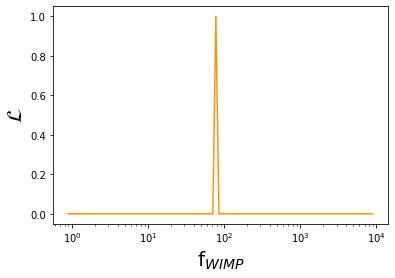

In [28]:
fig, axs = plt.subplots()
axs.plot(fwimps, np.exp(-0.5*(S - S.min())), color='xkcd:tangerine', label='P(C)')
# axs.plot(fwimps, S)
axs.set_xlabel(r'f$_{WIMP}$', fontsize=20)
axs.set_xscale('log')
# axs.set_ylabel(r'$\mathcal{S}-\mathcal{S}_{min}$', fontsize=20)
axs.set_ylabel(r'$\mathcal{L}$', fontsize=20)
# axs.set_ylim(bottom=0, top=1)
print(p['fwimp'], 'fwimp:', fwimps[S.argmin()], '\t S:', S.min())
# print('max L:', np.exp(-0.5*S.min()))

In [29]:
S

array([1232968.70726313, 1202462.97605045, 1171752.17824667,
       1141082.00348043, 1110672.23412233, 1080711.11954034,
       1051355.0184427 , 1022732.07152192,  994947.87434657,
        968091.43778983,  942240.2770102 ,  917463.97240209,
        893825.96822099,  871382.52217072,  850178.41838277,
        830244.34486178,  811599.56502021,  794259.41704666,
        778241.08111245,  763554.36350893,  750186.57698933,
        738105.49869071,  727260.82664901,  717592.95720815,
        709024.23853077,  701437.29338621,  694692.4609466 ,
        688641.9781923 ,  683101.2955541 ,  677874.20666973,
        672771.08911714,  667652.38430607,  662505.72672233,
        657356.66116064,  652217.45110204,  647120.26326165,
        642085.53336639,  637149.15732491,  632343.00857863,
        627707.23242874,  623285.87364377,  619126.05499474,
        615283.335496  ,  611815.1364649 ,  608788.06818369,
        606272.28036405,  604346.0347526 ,  603093.36588056,
        602605.51288647,

In [30]:
subcounts, np.mean(subcounts), np.std(subcounts)

(array([49., 61., 59., ..., 55., 55., 81.]),
 80.0321338959854,
 43.089311963179156)

In [31]:
subcounts, np.mean(subcounts), np.std(subcounts)

(array([49., 61., 59., ..., 55., 55., 81.]),
 80.0321338959854,
 43.089311963179156)

In [32]:
importlib.reload(pd)
Spoi, fwimpspoi = pd.poisson_likelihood(p, psh, subcounts.astype(np.int16), fluxes, counts, fwimp_limits=fwimp_search)

In [33]:
S-S.min()

array([6.30363194e+05, 5.99857463e+05, 5.69146665e+05, 5.38476491e+05,
       5.08066721e+05, 4.78105607e+05, 4.48749506e+05, 4.20126559e+05,
       3.92342361e+05, 3.65485925e+05, 3.39634764e+05, 3.14858460e+05,
       2.91220455e+05, 2.68777009e+05, 2.47572905e+05, 2.27638832e+05,
       2.08994052e+05, 1.91653904e+05, 1.75635568e+05, 1.60948851e+05,
       1.47581064e+05, 1.35499986e+05, 1.24655314e+05, 1.14987444e+05,
       1.06418726e+05, 9.88317805e+04, 9.20869481e+04, 8.60364653e+04,
       8.04957827e+04, 7.52686938e+04, 7.01655762e+04, 6.50468714e+04,
       5.99002138e+04, 5.47511483e+04, 4.96119382e+04, 4.45147504e+04,
       3.94800205e+04, 3.45436444e+04, 2.97374957e+04, 2.51017195e+04,
       2.06803608e+04, 1.65205421e+04, 1.26778226e+04, 9.20962358e+03,
       6.18255530e+03, 3.66676748e+03, 1.74052187e+03, 4.87852994e+02,
       0.00000000e+00, 3.75321634e+02, 1.71924464e+03, 4.14473641e+03,
       7.77205144e+03, 1.27289589e+04, 1.91506177e+04, 2.71795152e+04,
      

P(C) min of -2 ln L: 602605.5128864672
Poisson min of -2 ln L: 79463.0731708503


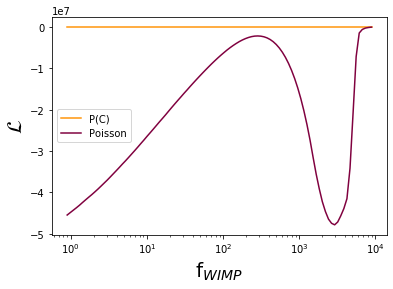

In [34]:
axs.plot(fwimpspoi, (-(Spoi-Spoi.min())), color='xkcd:wine', label='Poisson')
axs.legend()
axs.set_yscale('linear')
print('P(C) min of -2 ln L:', S.min())
print('Poisson min of -2 ln L:', Spoi.min())
fig

In [35]:
print(fwimps[Spoi.argmin()], Spoi.min())
print(np.log10(np.e)*1500)

8948.173222478577 79463.0731708503
651.4417228548778


In [36]:
from astropy.io import fits
bg = fits.open('output/background.fits')

FileNotFoundError: [Errno 2] No such file or directory: 'output/background.fits'

In [ ]:
bg[0].header

In [ ]:
a = np.reshape(np.arange(9), (3, 3))
print(a)
a[np.array([[1, 0], [1, 2] , [2, 1]])]

In [ ]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self, x):
        return custom_pdf(x)
    
    def _cdf(self, x):
        return custom_cdf(x)
    
    def _ppf(self, x):
        return custom_ppf(x)

In [ ]:
psi = 50
custom_pdf = lambda x: pshfunc2d(psi, x).flatten()

norm = np.trapz(pshfunc2d(psi, fluxes).flatten(), fluxes)
discrete_cdf = integrate.cumtrapz(pshfunc2d(psi, fluxes).flatten(), fluxes, initial=0)
custom_cdf = intp.interp1d(fluxes, discrete_cdf, fill_value=0, bounds_error=False)

custom_ppf = intp.interp1d(discrete_cdf, fluxes, fill_value=0, bounds_error=False)

func50 = my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
# pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)

def pc(psi, counts_max=15):
    counts = np.arange(0, counts_max + 1)
    
    pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
    custom_pdf = intp.interp1d(counts, pcvals, fill_value=0, bounds_error=False)
    
    discrete_cdf = integrate.cumtrapz(pcvals, counts, initial=0)
    custom_cdf = intp.interp1d(counts, discrete_cdf, fill_value=0, bounds_error=False)

    custom_ppf = intp.interp1d(discrete_cdf, counts, fill_value=0, bounds_error=False)
    
    return my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
pc(50).rvs(size=10)

In [ ]:
psi = 40
pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
pp = poisson.pmf(counts, exposure*fluxes[np.argmax(pshfunc2d(psi, fluxes))])

print(np.sum(pcvals/np.sum(pcvals)))
plt.plot(counts, pcvals)
plt.plot(counts, pp)
plt.hist(np.random.choice(np.arange(len(pcvals)), size=100000, p=pcvals/np.sum(pcvals)))

ax = plt.gca()
ax.set_yscale('log')
# ax.set_ylim(top=1, bottom=1e-20)
ax.set_xlabel('Counts')
# ax.set_xscale('log')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [ ]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(fluxes.min()), np.log10(fluxes.max()), num=50)
ax.hist(func50.rvs(size=100000), bins=bins)
ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$")
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
for i, latt in enumerate(lat):
    if latt < 40:
        pixel_counts[i] = 0
    else:
        